# Import Library

In [1]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -U "tensorflow==2.8.*"
!pip install -U "tensorflow-text==2.8.*"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 3 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 7s (59.0 MB/s)
(Reading database ... 123942 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 to 

In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as text

from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
from tensorflow.keras import layers

# Data Preparation

## Download Dataset

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/208106 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incompleteH3QL6J/ted_hrlr_translate-train.tf…

Generating validation examples...:   0%|          | 0/4805 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incompleteH3QL6J/ted_hrlr_translate-validati…

Generating test examples...:   0%|          | 0/5476 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incompleteH3QL6J/ted_hrlr_translate-test.tfr…

Dataset ted_hrlr_translate downloaded and prepared to ~/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_examples, val_examples = examples['train'], examples['validation']

In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Russian:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Russian:
к : успех , перемены возможны только с оружием в руках .
документация и методика практического обучения также доступна и выпущена creative commons .
( видео ) диди пиклз : сейчас четыре часа утра .

> Examples in English:
c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


## Tokenization

In [6]:
train_en = train_examples.map(lambda ru, en: en)
train_ru = train_examples.map(lambda ru, en: ru)

In [7]:
bert_tokenizer_params = dict(lower_case=True)
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

In [8]:
bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [ ]:
# No need to run this function if you already have vocab file
%%time
en_vocab = bert_vocab.bert_vocab_from_dataset(
    train_en.batch(1000).prefetch(2),
    **bert_vocab_args
)

In [ ]:
# No need to run this function if you already have vocab file
%%time
ru_vocab = bert_vocab.bert_vocab_from_dataset(
    train_ru.batch(1000).prefetch(2),
    **bert_vocab_args
)

In [ ]:
# No need to run this function if you already have vocab file
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [ ]:
# No need to run this function if you already have vocab file
write_vocab_file('en_vocab.txt', en_vocab)
write_vocab_file('ru_vocab.txt', ru_vocab)

In [9]:
import pathlib
import re

START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

In [10]:
tokenizers = tf.Module()
tokenizers.ru = CustomTokenizer(reserved_tokens, 'ru_vocab.txt')
tokenizers.en = CustomTokenizer(reserved_tokens, 'en_vocab.txt')

In [11]:
model_name = 'ted_hrlr_translate_ru_en_converter'
tf.saved_model.save(tokenizers, model_name)

In [12]:
def tokenize_pairs(ru, en):
    ru = tokenizers.ru.tokenize(ru)
    ru = ru.to_tensor()

    en = tokenizers.en.tokenize(en)
    en = en.to_tensor()
    return ru, en

In [13]:
BATCH_SIZE = 32
BUFFER_SIZE = 20000
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE)
  )

## Testing Dataset

In [14]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [15]:
list(train_batches.take(2).as_numpy_iterator())

[(array([[   2, 1515, 1298, ...,    0,    0,    0],
         [   2,  629,  709, ...,    0,    0,    0],
         [   2,  132, 5902, ...,    0,    0,    0],
         ...,
         [   2,   10,  178, ...,    0,    0,    0],
         [   2,   79, 5809, ...,    0,    0,    0],
         [   2,   10,  454, ...,    0,    0,    0]]),
  array([[  2, 402,  14, ...,   0,   0,   0],
         [  2, 391, 125, ...,   0,   0,   0],
         [  2,  92, 105, ...,   0,   0,   0],
         ...,
         [  2,  10, 171, ...,   0,   0,   0],
         [  2,  85, 476, ...,   0,   0,   0],
         [  2,  10, 400, ...,   0,   0,   0]])),
 (array([[   2,  135,  133, ...,    0,    0,    0],
         [   2,  260,  139, ...,    0,    0,    0],
         [   2,  245,  137, ...,  757,   16,    3],
         ...,
         [   2,   77,  373, ...,    0,    0,    0],
         [   2,  137, 1284, ...,    0,    0,    0],
         [   2, 5489, 1585, ...,    0,    0,    0]]),
  array([[   2,  102,   91, ...,    0,    0,    0],

# Model

## Positional Encoding

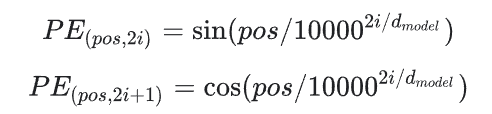

In [16]:
def positional_encoding(position, d_model):
  i = np.arange(d_model)[np.newaxis,:]
  pos = np.arange(position)[:, np.newaxis]

  angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
  angle_rads = pos * angle_rates

  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

## Multi Head Attention

In [17]:
def scaled_dot_product_attention(q, k, v, mask):
    # get dimensions of the input, cast from tensor to float
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    
    # compute queries x keys and scale by dimension
    attention_logits = tf.matmul(q, k, transpose_b=True)
    
    scaled_attention_logits = attention_logits / tf.math.sqrt(d_k)

    # apply decoder mask
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # normalize all scores
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # times value
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [18]:
class MultiHeadAttention(layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()

    self.d_model = d_model
    self.num_heads = num_heads

    self.depth = self.d_model // num_heads

    self.wq = layers.Dense(d_model)
    self.wk = layers.Dense(d_model)
    self.wv = layers.Dense(d_model)

    self.dense = layers.Dense(d_model)
  
  def split_heads(self, x, batch_size):
    new_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(new_x, perm=[0, 2, 1, 3])
  
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.split_heads(self.wq(q), batch_size)
    k = self.split_heads(self.wk(k), batch_size)
    v = self.split_heads(self.wv(v), batch_size)

    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    return self.dense(concat_attention), attention_weights

Testing

In [19]:
tf.random.set_seed(8)
multi_head_attention = MultiHeadAttention(512, 8)

x = tf.ones((1,60, 512))
out, attn = multi_head_attention(x, k=x, q=x, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Encoder & Decoder

In [20]:
def ffnn(d_model, d_ff):
  return tf.keras.Sequential([layers.Dense(d_ff, activation='relu'), layers.Dense(d_model)])

In [21]:
class EncoderLayer(layers.Layer):
  def __init__(self, d_model, num_heads, d_ffnn, dropout_rate = 0.1):
    super(EncoderLayer, self).__init__()

    self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
    self.ffnn = ffnn(d_model, d_ffnn)

    self.layer_norm_1 = layers.LayerNormalization(epsilon=1e-6)
    self.layer_norm_2 = layers.LayerNormalization(epsilon=1e-6)

    self.dropout_1 = layers.Dropout(dropout_rate)
    self.dropout_2 = layers.Dropout(dropout_rate)

  def call(self, x, training, mask):
    att_output, _ = self.multi_head_attention(x, x, x, mask)
    dropout_1 = self.dropout_1(att_output, training=training)
    output_1 = self.layer_norm_1(x + dropout_1)

    ffnn_output = self.ffnn(output_1)
    dropout_2 = self.dropout_2(ffnn_output, training=training)
    output_2 = self.layer_norm_2(output_1 + dropout_2)

    return output_2

Testing

In [22]:
tf.random.set_seed(8)

sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

In [23]:
class Encoder(layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, d_ffnn, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, d_ffnn, dropout_rate) for i in range(num_layers)]
    self.dropout = layers.Dropout(dropout_rate)
  
  def call(self, x, training, mask):
    seq_len = tf.shape(x)[1]
        
    new_x = self.embedding(x)
    new_x *= tf.sqrt(tf.cast(self.d_model, tf.float32))
    new_x += self.pos_encoding[:, :seq_len, :]
    
    new_x = self.dropout(new_x, training=training)
    for i in range(self.num_layers):
        new_x = self.enc_layers[i](new_x, training, mask)

    return new_x

Testing

In [24]:
tf.random.set_seed(8)

sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, d_ffnn=2048, input_vocab_size=8500, maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

sample_encoder_output.shape

TensorShape([64, 62, 512])

In [25]:
class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, d_ffnn, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mmha = MultiHeadAttention(d_model, num_heads)
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffnn = ffnn(d_model, d_ffnn)

        self.layer_norm_1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm_2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm_3 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout_1 = layers.Dropout(dropout_rate)
        self.dropout_2 = layers.Dropout(dropout_rate)
        self.dropout_3 = layers.Dropout(dropout_rate)

    def call(self, x, encoder_out, training, look_ahead_mask, padding_mask):
        mask_attn_out, attn_weights_block1 = self.mmha(x, x, x, look_ahead_mask)
        mask_attn_out = self.dropout_1(mask_attn_out, training=training)
        out1 = self.layer_norm_1(mask_attn_out + x)

        attn_out, attn_weights_block2 = self.mha(encoder_out, encoder_out, out1, padding_mask)
        attn_out = self.dropout_2(attn_out, training=training)
        out2 = self.layer_norm_2(attn_out + out1)

        ff_out = self.ffnn(out2)
        ff_out = self.dropout_3(ff_out, training=training)
        out3 = self.layer_norm_3(ff_out + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [26]:
class Decoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, d_ff, target_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, d_ff, dropout_rate) for i in range(num_layers)]
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training,  look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attn_weights = {}
        
        x = self.embedding(x)
        x *= tf.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask,padding_mask)

            attn_weights[f'decoder_layer{i+1}_block1'] = block1
            attn_weights[f'decoder_layer{i+1}_block2'] = block2

        return x, attn_weights

Testing

In [27]:
tf.random.set_seed(8)

sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, d_ff=2048, target_vocab_size=8000, maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)
output, attn = sample_decoder(temp_input, enc_output=sample_encoder_output, training=False, look_ahead_mask=None,padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformer

In [28]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size, target_vocab_size, pe_input, pe_target, dropout_rate=0.1):
    super(Transformer, self).__init__()
    
    self.encoder = Encoder(num_layers, d_model, num_heads, d_ff, input_vocab_size, pe_input, dropout_rate)
    self.decoder = Decoder(num_layers, d_model, num_heads, d_ff, input_vocab_size, pe_target, dropout_rate)
    self.final_layer = layers.Dense(target_vocab_size)
        
  def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
    enc_output = self.encoder(inp, training, enc_padding_mask)
    dec_output, attention_weights  = self.decoder(tar, enc_output, training, look_ahead_mask,dec_padding_mask)

    return self.final_layer(dec_output), attention_weights

Testing

In [29]:
tf.random.set_seed(42)

sample_transformer = Transformer(num_layers=2, d_model=512, num_heads=8, d_ff=2048, input_vocab_size=8500, target_vocab_size=8000, pe_input=10000, pe_target=6000)
temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)
fn_out, _ = sample_transformer(temp_input, temp_target, training=False, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None)

fn_out.shape

TensorShape([64, 36, 8000])

## Training

Hyperparameter

In [30]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

Setup Optimizer

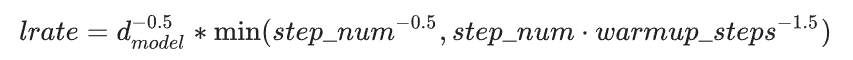

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps = 4000):
    super(CustomSchedule, self).__init__()
  
    self.warmup_steps = warmup_steps
    self.d_model = tf.cast(d_model, dtype=tf.float32)

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [32]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Testing

Text(0.5, 0, 'Train Step')

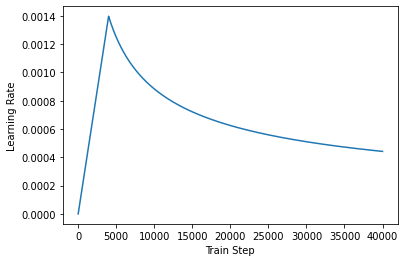

In [33]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

Setup Loss

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [35]:
def loss_function(label, pred):
  mask = tf.math.logical_not(tf.math.equal(label, 0))
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  return tf.reduce_sum(loss)/tf.reduce_sum(mask)

def accuracy_function(label, pred):
  accuracies = tf.equal(label, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(label, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)

  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [36]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

Training Model Preparation

In [37]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [38]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [39]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

Training Model

In [40]:
transformer = Transformer(
    num_layers = num_layers, 
    d_model = d_model, 
    num_heads = num_heads, 
    d_ff = dff, 
    input_vocab_size = tokenizers.ru.get_vocab_size(), 
    target_vocab_size = tokenizers.en.get_vocab_size(), 
    pe_input = 10000, 
    pe_target = 6000,
    dropout_rate = dropout_rate,
)

In [41]:
!rm -rf ./checkpoints/

In [45]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [46]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [47]:
import time

EPOCHS = 3
step = 0
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> russian, tar -> english
    for (batch, (inp, tar)) in enumerate(train_batches):
        train_step(inp, tar)

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    ckpt_save_path = ckpt_manager.save()
    
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 4.2233 Accuracy 0.2957
Epoch 1 Batch 50 Loss 4.2041 Accuracy 0.2985
Epoch 1 Batch 100 Loss 4.1901 Accuracy 0.2987
Epoch 1 Batch 150 Loss 4.1818 Accuracy 0.2981
Epoch 1 Batch 200 Loss 4.1749 Accuracy 0.2972
Epoch 1 Batch 250 Loss 4.1722 Accuracy 0.2973
Epoch 1 Batch 300 Loss 4.1721 Accuracy 0.2975
Epoch 1 Batch 350 Loss 4.1674 Accuracy 0.2982
Epoch 1 Batch 400 Loss 4.1637 Accuracy 0.2986
Epoch 1 Batch 450 Loss 4.1651 Accuracy 0.2984
Epoch 1 Batch 500 Loss 4.1648 Accuracy 0.2983
Epoch 1 Batch 550 Loss 4.1632 Accuracy 0.2986
Epoch 1 Batch 600 Loss 4.1617 Accuracy 0.2986
Epoch 1 Batch 650 Loss 4.1603 Accuracy 0.2988
Epoch 1 Batch 700 Loss 4.1605 Accuracy 0.2986
Epoch 1 Batch 750 Loss 4.1579 Accuracy 0.2990
Epoch 1 Batch 800 Loss 4.1564 Accuracy 0.2993
Epoch 1 Batch 850 Loss 4.1561 Accuracy 0.2993
Epoch 1 Batch 900 Loss 4.1537 Accuracy 0.2996
Epoch 1 Batch 950 Loss 4.1505 Accuracy 0.2999
Epoch 1 Batch 1000 Loss 4.1510 Accuracy 0.2998
Epoch 1 Batch 1050 Loss 4.1488 Accur

In [48]:
def evaluate(sentence, max_length=40):
    # inp sentence is russian, hence adding the start and end token
    sentence = tf.convert_to_tensor([sentence])
    sentence = tokenizers.ru.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # as the target is english, the first word to the transformer should be the
    # english start token.
    start, end = tokenizers.en.tokenize([''])[0]
    output = tf.convert_to_tensor([start])
    output = tf.expand_dims(output, 0)

    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                    output,
                                                    False,
                                                    enc_padding_mask,
                                                    combined_mask,
                                                    dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.argmax(predictions, axis=-1)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == end:
            break

    # output.shape (1, tokens)
    print(output)
    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]

    return text, tokens, attention_weights

In [49]:
tokenizers.en.tokenize([''])[0]

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 3])>

In [50]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [52]:
sentence = "где твой дом"
ground_truth = "Where is your home"

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

tf.Tensor([[  2 167 150 603  93  16   3]], shape=(1, 7), dtype=int64)
Input:         : где твой дом
Prediction     : where your house is .
Ground truth   : Where is your home
